# Real Box Office Data Analysis

## Overview

This project analyzes a set of real box office data (provided by flatiron school) which includes information gathered from IMDB, ThemovieDB, and The Numbers in order to provide business insights for the investors looking to open a new movie studio. The data used in this project includes the profit, aggregate review scores, genres, and number of markets that each movie was released in. Film industry investors can use this analysis to guide their decisions as they decide what kind of movies to create.

## Business Problem

Film industry investors may be able to use this analysis to determine which genres of movie to create in order to create the most successful movie, with profit being the main indicator of success. I also provide mathematical recommendations for their investment based on patterns I observed in the data. The purpose of this project is to provide guidelines for investors on how much to invest, where to invest it, and how to invest it in order to make the most profitable movie.

## Data explaination

The data files used for the analysis are not included within this repository in order to reflect industry best practicies and to simulate the process I would follow if I were working with private and sensitive data. The zipped data can be obtained at the flatiron school repository which served as a model example for this project, accessible [here.](https://github.com/learn-co-curriculum/dsc-phase-2-project-v3/tree/gating/zippedData) The original dataset also contains information from Box Office Mojo and Rotten Tomatoes, which I did not use in my analysis. The data contains a wide array of statistics about each movie, but only the statistics relevant to the purpose of this study were used. This includes the production budget of the movie, the gross profit across all markets, the original language of the movie, genres, and the number of markets each movie was released in.

## Data Assembly and Cleaning

In my exploratory analysis, I found that out of the five sources of data I have assembled for the project, only three of them were well suited to my analysis. The Box Office Mojo data is an inferior version of the data from The Numbers, and joining the Rotten Tomatoes data with everything else would result in a huge amount of lost entries/NaN values, meaning it was not feasible to include it. In the cells below, I assemble the data into a single dataframe and clean out the missing and placeholder values from the columns I plan to use in my analysis.

In [1]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import seaborn as sns
from pandasql import sqldf
from scipy import stats

In [2]:
# Load TMDB data
tmdbdf = pd.read_csv("data/tmdb.movies.csv")
# Trim columns from TMDB data that are not useful for this analysis, reformat data to be easier to work with
tmdbdf.drop(columns=['id', 'Unnamed: 0', 'genre_ids', 'release_date'], inplace=True)
tmdbdf.columns = ['original_language', 'original_title', 'popularity', 'title', 'TMDBvote_average', 'TMDBvote_count']
tmdbdf.set_index('original_title', inplace=True)

# Load data from The Numbers
tndf = pd.read_csv("data/tn.movie_budgets.csv")
# Same trimming process as above
tndf.drop(columns='id', inplace=True)
tndf.set_index('movie', inplace=True)

# Set up connection to IMDB SQL database
conn = sqlite3.connect('data/im.db')

# Query SQL database for IMDB ratings and number of regions movies were released in
q = """
SELECT primary_title, averagerating AS IMDBrating, genres, numvotes AS IMDBnumvotes, COUNT(DISTINCT region) AS num_markets
  FROM movie_basics as MB
  JOIN movie_ratings as MR
      USING(movie_id)
  JOIN movie_akas
      USING(movie_id)
GROUP BY primary_title
"""
imdbdf = pd.read_sql(q, conn)
imdbdf.set_index('primary_title', inplace=True)

# Join dataframes together to create the main source of data I will use in this analysis
fulldf = tndf.join([tmdbdf, imdbdf], how='inner')

# Trim out a duplicate column, calculate a new profit column, and then drop the now-redundant columns that were used to calculate it
# Remove the dollar signs and commas, then convert data type to integer
fulldf['worldwide_gross'] = fulldf['worldwide_gross'].map(lambda x: int(x.replace(",", "")[1:]))
fulldf['production_budget'] = fulldf['production_budget'].map(lambda x: int(x.replace(",", "")[1:]))
# Calculate the new profit column: worldwide gross - production budget
fulldf['profit'] = fulldf['worldwide_gross'] - fulldf['production_budget'] 
fulldf.drop(columns=['domestic_gross', 'worldwide_gross', 'title'], inplace=True)
fulldf.head()

,release_date,production_budget,original_language,popularity,TMDBvote_average,TMDBvote_count,IMDBrating,genres,IMDBnumvotes,num_markets,profit
#Horror,"Nov 20, 2015",1500000,de,6.099,3.3,102,3.0,"Crime,Drama,Horror",3092,3,-1500000
10 Cloverfield Lane,"Mar 11, 2016",5000000,en,17.892,6.9,4629,7.2,"Drama,Horror,Mystery",260383,25,103286422
10 Days in a Madhouse,"Nov 11, 2015",12000000,en,0.955,5.4,7,6.7,Drama,1114,2,-11985384
12 Strong,"Jan 19, 2018",35000000,en,13.183,5.6,1312,6.6,"Action,Drama,History",50155,26,36118378
12 Years a Slave,"Oct 18, 2013",20000000,en,16.493,7.9,6631,8.1,"Biography,Drama,History",577301,32,161025343


The programming that was used to create this dataframe was written originally in the exploration branch of this repository, where I did my exploratory analysis. Now that I have the data I want to use in a workable format, I will provide a statistical overview and check for missing values and obvious placeholders.

In [3]:
fulldf.describe()

,production_budget,popularity,TMDBvote_average,TMDBvote_count,IMDBrating,IMDBnumvotes,num_markets,profit
count,2.140000e+03,2140.000000,2140.000000,2140.000000,2140.000000,2.140000e+03,2140.000000,2.140000e+03
mean,3.877142e+07,10.868855,6.206355,1760.184579,6.261075,9.649431e+04,20.400000,8.370660e+07
std,5.249873e+07,8.317120,1.127242,2749.367955,1.103754,1.537298e+05,10.884141,1.865289e+08
min,9.000000e+03,0.600000,0.000000,1.000000,1.600000,5.000000e+00,1.000000,-1.104502e+08
25%,5.000000e+06,5.860250,5.600000,71.000000,5.700000,2.986000e+03,12.000000,-1.500000e+06
50%,2.000000e+07,9.592500,6.300000,675.500000,6.400000,3.874000e+04,23.000000,1.417473e+07
75%,4.800000e+07,14.502750,6.900000,2148.250000,7.000000,1.190545e+05,29.000000,7.918545e+07
max,4.250000e+08,80.773000,10.000000,22186.000000,9.200000,1.841066e+06,48.000000,2.351345e+09


A potential issue with this dataset is the small number of records that I've ended up with. The IMDB database is rather large. However, due to the reliance of my analysis on profit as a metric of success, I can only use records that overlap with the data from The Numbers. These two datasets only share about 2000 records, limiting the size of my data. I believe that this size is still sufficient for the purposes of my study, as these movies are likely representative of the population of all movies.

In [4]:
fulldf.isna().any()

release_date         False
production_budget    False
original_language    False
popularity           False
TMDBvote_average     False
TMDBvote_count       False
IMDBrating           False
genres                True
IMDBnumvotes         False
num_markets          False
profit               False
dtype: bool

In [5]:
fulldf.isna().sum()

release_date         0
production_budget    0
original_language    0
popularity           0
TMDBvote_average     0
TMDBvote_count       0
IMDBrating           0
genres               2
IMDBnumvotes         0
num_markets          0
profit               0
dtype: int64

Thankfully, the only  missing columns are in a column that I plan to do a completely separate analysis on, and it's only missing two values anyway - I'll handle those later. Now, I'm going to check the columns that are imortant for my analysis to see if I can spot any obvious placeholder values.

In [6]:
fulldf['production_budget'].value_counts().head(10)

10000000    95
20000000    87
5000000     76
25000000    71
30000000    68
40000000    57
15000000    54
35000000    53
2000000     48
12000000    47
Name: production_budget, dtype: int64

It looks like the values in production budget have been rounded into bins by tens of millions of dollars, but nothing here immediately jumps out as a placeholder (I would expect something like $0).

In [7]:
fulldf['TMDBvote_average'].value_counts().head(10)

6.2    99
5.9    98
6.0    98
6.1    96
6.6    91
6.7    90
5.8    90
6.3    89
6.8    86
6.5    78
Name: TMDBvote_average, dtype: int64

In [8]:
fulldf['IMDBrating'].value_counts().head(10)

6.4    98
6.6    95
6.5    93
6.3    91
6.2    88
6.7    79
6.8    78
7.1    77
7.2    75
6.1    73
Name: IMDBrating, dtype: int64

Neither of my rating aggregate columns seem to have obvious placeholder values either, which is good. I just need to check the number of markets column and original language columns now.

In [9]:
fulldf['num_markets'].value_counts().head(10)

29    114
26    105
27     93
1      87
28     82
24     80
2      79
30     75
25     72
23     71
Name: num_markets, dtype: int64

This is also looking perfect.

In [10]:
fulldf['original_language'].value_counts()

en    2092
fr      13
es       8
hi       4
de       4
et       2
ko       2
ar       2
xx       1
da       1
gu       1
tr       1
fa       1
pt       1
te       1
tl       1
pl       1
it       1
ur       1
fi       1
th       1
Name: original_language, dtype: int64

For the analysis I plan to do on this column, having a large number of original languages with only one movie is unacceptable. My solution to this is to drop the original languages that have less than four entries to ensure that there is at least a reasonable spread of values within each. I don't want to prune out rows from the main dataframe either due to its already limited size, so I am going to create a separate dataframe with these changes.

In [11]:
langdf = fulldf[fulldf.groupby('original_language').original_language.transform('count')>3].copy() 
langdf['original_language'].value_counts()

en    2092
fr      13
es       8
de       4
hi       4
Name: original_language, dtype: int64

The code I used to make that change was taken from [this incredibly helpful Stack Overflow page.](https://stackoverflow.com/questions/49735683/python-removing-rows-on-count-condition)

I also want to simplify the ratings columns by combining the ratings from both sources together using a weighted average, based on the total number of reviews from each source. This shouldn't be too difficult for me to do.

In [12]:
# Calculate the total number of reviews each movie recieved
fulldf['total_num_reviews'] = fulldf['TMDBvote_count'] + fulldf['IMDBnumvotes']

# Calculate the number of reviews that were from IMDB or TMDB as a percentage
fulldf['TMDB_percentage'] = fulldf['TMDBvote_count'] / fulldf['total_num_reviews']
fulldf['IMDB_percentage'] = fulldf['IMDBnumvotes'] / fulldf['total_num_reviews']

# Calculate the weighted average by multiplying the aggregate score from each source by the source's percentage of votes and adding them together
fulldf['aggregate_score'] = (fulldf['TMDB_percentage'] * fulldf['TMDBvote_average']) + (fulldf['IMDB_percentage'] * fulldf['IMDBrating'])

# Display the result
fulldf['aggregate_score']

#Horror                       3.009580
10 Cloverfield Lane           7.194760
10 Days in a Madhouse         6.691882
12 Strong                     6.574508
12 Years a Slave              8.097729
                                ...   
Zookeeper                     5.201663
Zoolander 2                   4.700000
Zoom                          6.089096
Zootopia                      7.992392
xXx: Return of Xander Cage    5.212195
Name: aggregate_score, Length: 2140, dtype: float64

I am happy with this result, so I am going to drop the extra columns I just created and the original columns that contained the aggregate scores and score counts to make the final dataframe much easier to read.

In [13]:
fulldf.drop(columns=['TMDB_percentage', 'IMDB_percentage', 'total_num_reviews', 'TMDBvote_count', 'IMDBnumvotes', 'TMDBvote_average', 'IMDBrating'], inplace=True)
fulldf

,release_date,production_budget,original_language,popularity,genres,num_markets,profit,aggregate_score
#Horror,"Nov 20, 2015",1500000,de,6.099,"Crime,Drama,Horror",3,-1500000,3.009580
10 Cloverfield Lane,"Mar 11, 2016",5000000,en,17.892,"Drama,Horror,Mystery",25,103286422,7.194760
10 Days in a Madhouse,"Nov 11, 2015",12000000,en,0.955,Drama,2,-11985384,6.691882
12 Strong,"Jan 19, 2018",35000000,en,13.183,"Action,Drama,History",26,36118378,6.574508
12 Years a Slave,"Oct 18, 2013",20000000,en,16.493,"Biography,Drama,History",32,161025343,8.097729
...,...,...,...,...,...,...,...,...
Zookeeper,"Jul 8, 2011",80000000,en,10.764,"Comedy,Family,Romance",30,90805525,5.201663
Zoolander 2,"Feb 12, 2016",50000000,en,12.997,Comedy,17,5348693,4.700000
Zoom,"Aug 11, 2006",35000000,en,3.434,"Animation,Comedy,Drama",7,-22493812,6.089096
Zootopia,"Mar 4, 2016",150000000,en,27.549,"Adventure,Animation,Comedy",45,869429616,7.992392


I also want to include an analysis of different genres, so I will need to do a little bit of extra work to get that column into a workable structure. My plan is to make a separate dataframe with the genre string split into its parts, and then create the unique set of genres that are listed in the data. Then, I will modify this separate dataframe so that it has a column for each genre in that list with a true/false value for each movie alongside the profit the movie earned.

In [14]:
# drop NaNs and separate individual genre names by commas
fulldf['genres'].dropna(inplace=True)
fulldf['genres'] = fulldf['genres'].str.split(',')

In [15]:
# Create a flat list of all the unique genres in the data
genres = []
genres.extend(fulldf['genres'].tolist())
flatgenres = []
for sublist in genres:
    if sublist == None:
        continue
    else: 
        for item in sublist:
            flatgenres.append(str(item))
flatgenres = list(set(flatgenres))
flatgenres

['Drama',
 'Mystery',
 'Animation',
 'Adventure',
 'Music',
 'History',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'Sport',
 'Biography',
 'Family',
 'Fantasy',
 'Crime',
 'Musical',
 'Western',
 'War',
 'Action',
 'Documentary',
 'Horror',
 'Comedy',
 'News']

In [16]:
# Drop the columns I do not want in this DF and then create a new column for each genre, filled with False by default
genredf = fulldf.drop(columns=['release_date', 'production_budget', 'original_language', 'popularity', 'num_markets', 'aggregate_score'])
for item in flatgenres:
    genredf[item] = False
genredf.reset_index(inplace=True)

In [17]:
# Loop through the list of genres. For each genre, check if each movie has that genre. If it does, set the corresponding genre column for that movie to True.
for item in flatgenres:
    for index, entry in enumerate(genredf['genres']):
        # There are some nonetype entires for some reason, so I need to handle this exception this this if statement.
        if entry == None:
            continue
        else:
            for genre in entry:
                if genre == item:
                    genredf.at[index, item] = True

In [18]:
# Create a dictionary with the average profit for each genre
genreprofitdict = {}
for genre in flatgenres:
    tempdf = genredf[genredf[genre] == True]
    avgprofit = tempdf['profit'].mean()
    genreprofitdict[genre] = avgprofit

That's the end of the preparation I needed to do before my analysis, so now I can move on to creating helpful graphs and linear regression models!

## Analysis

### Budget vs. Aggregate Score

The first step in my analysis is to establish the correlation between production budget and average aggregate score of the films. I plan to do this with a scatter plot and a simple linear regression model.

In [19]:
# Import statsmodels to create a linear regression model, set seaborn style
import statsmodels.api as sm
plt.style.use('seaborn-whitegrid')

In [20]:
# Create regression model and display the summary of results
BSmodel = sm.OLS(endog = fulldf['aggregate_score'], exog = sm.add_constant(fulldf['production_budget']))
BSresults = BSmodel.fit()
print(BSresults.summary())

                            OLS Regression Results                            
Dep. Variable:        aggregate_score   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     87.22
Date:                Wed, 30 Aug 2023   Prob (F-statistic):           2.36e-20
Time:                        12:01:02   Log-Likelihood:                -3114.7
No. Observations:                2140   AIC:                             6233.
Df Residuals:                    2138   BIC:                             6245.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 6.1114      0.02

There's quite a bit of interpretation I can do with these results. First of all, this model predicts that even with a budget of 0 dollars, you will expect the minimum average score your movie will recieve to be 6.1114. The slope of the line can be interpreted to mean that for every $1,000,000 of production budget, on average, the aggregate score of the movie will increase by 0.004. This doesn't mean that spending more money on production is guaranteed to get you higher reviews, but it does mean that we expect that to happen on average, and it does establish a correlation between the two.

The p-statistics of the coefficients and the entire model are extremely low, meaning that essentially no matter what alpha value we may have chosen, the model will still be considered statistically significant. It is very unlikely that this prediction is simply due to sampling error, and it is much more likely that there really is some effect that is causing movies with higher production values to get better reviews.

It is important to consider note number 2 of the description printout. Statsmodels predicts that there are multicollinearity factors in the dataset which are affecting this model. The best thing to do in this situation would be to create a multiple linear regression model instead of creating many single linear regressions like I do in this notebook in order to account for the multiple factors that are contributing to aggregate ratings and scores of movies. This is intended just to be a basic analysis, and the single linear regression models should be just fine for the purposes of my analysis.

Now, I will plot the linear regression like to show this result visually.

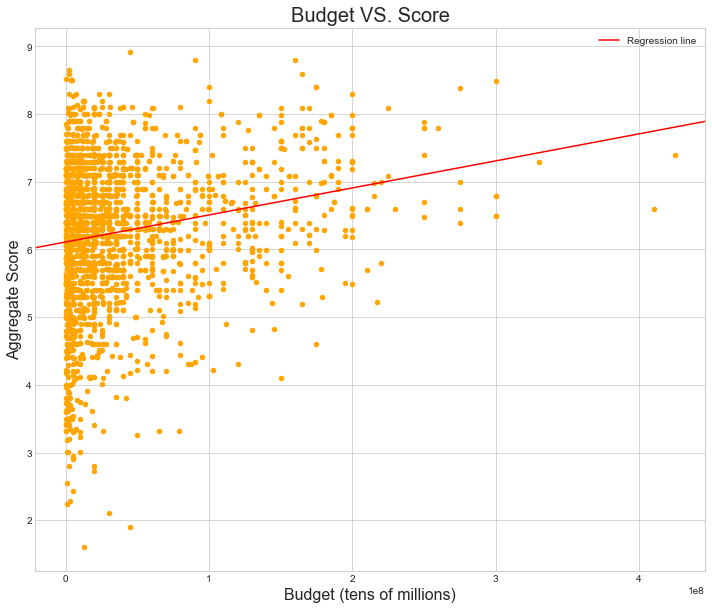

In [29]:
fig, ax1 = plt.subplots(figsize=(12,10))
fulldf.plot.scatter(x='production_budget', y='aggregate_score', ax=ax1, color='orange')
ax1.set_title('Budget VS. Score', fontsize=20)
ax1.set_xlabel('Budget (tens of millions)', fontsize=16)
ax1.set_ylabel('Aggregate Score', fontsize=16)
sm.graphics.abline_plot(model_results=BSresults, label='Regression line', ax=ax1, color='red')
ax1.legend();

Visually inspecting this graph, it is apparent that a logarithmic graph would likely fit the data slightly better than a simple linear model. However, I think this result is sufficient to establish the correlation I'm looking to prove - I could do an analysis of the residuals to show that a log transformation would make the model more accurate, but because this is an intermediate step in proving a more important connection, I'm going to leave it here.

### Aggregate Score vs. Profit

High user ratings are not the only metric of a movie's success: in fact, profit is much more interesting to investors who want to open a movie studio. For this reason, I also need to establish a correlation between the aggregate rating a movie recieves and the total profit it made.

In [22]:
ASPDmodel = sm.OLS(endog = fulldf['profit'], exog = sm.add_constant(fulldf['aggregate_score']))
ASPDresults = ASPDmodel.fit()
print(ASPDresults.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     145.9
Date:                Wed, 30 Aug 2023   Prob (F-statistic):           1.56e-32
Time:                        12:01:03   Log-Likelihood:                -43720.
No. Observations:                2140   AIC:                         8.744e+04
Df Residuals:                    2138   BIC:                         8.745e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.954e+08   2.34e+07     

This linear regression model predicts that for every 1 point increase in aggregate score, movie profit is exepected to increase by 44,540,000 dollars on average. It also predicts that if your movie gets an aggregate score of 0, you will lose approximately 195,400,000 dollars. The p-value of the model and its coefficients are very small, meaning that this effect is extremely unlikely to be due to sampling error or random chance. 

I'll make a visual representation of this regression model as well below.

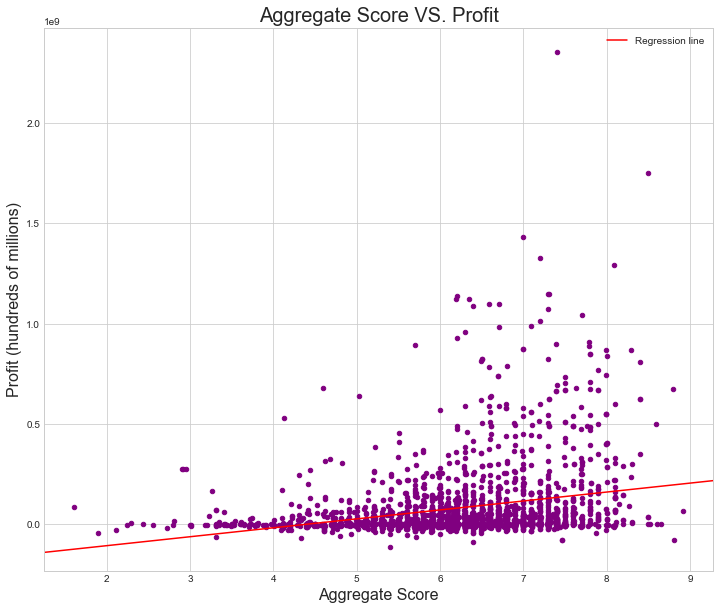

In [30]:
fig, ax2 = plt.subplots(figsize=(12,10))
fulldf.plot.scatter(x='aggregate_score', y='profit', ax=ax2, color='purple')
ax2.set_title('Aggregate Score VS. Profit', fontsize=20)
ax2.set_xlabel('Aggregate Score', fontsize=16)
ax2.set_ylabel('Profit (hundreds of millions)', fontsize=16)
sm.graphics.abline_plot(model_results=ASPDresults, label='Regression line', ax=ax2, color='red')
ax2.legend();

Unlike the previous graph, this one seems like an exponential function would be a better fit. I want to keep my analysis simple for now so I won't be applying this transformation, and I won't use the residuals to prove that this is necessary either. This model still proves a strong correlation between aggregate score and profit, so I am happy that this has proven the point that I wanted to make: Increasing the production budget of a movie will increase the average aggregate user score, which strongly correlates with an increase in profit. The more you invest into the movie, the better it will be, and the bigger your profit will be.

### Number of Markets vs. Profit

A large contributing factor to the success of a movie is how many different people it can be marketed to. Releasing a movie in a large number of markets is a great way to increase the size of your potential audience, and consequently increase your profit. In this part of the analysis, I will quantify the increase in profit that investors can expect per additional foreign market they release their film in.

In [24]:
NMPmodel = sm.OLS(endog = fulldf['profit'], exog = sm.add_constant(fulldf['num_markets']))
NMPresults = NMPmodel.fit()
print(NMPresults.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     560.2
Date:                Wed, 30 Aug 2023   Prob (F-statistic):          3.46e-110
Time:                        12:01:03   Log-Likelihood:                -43541.
No. Observations:                2140   AIC:                         8.709e+04
Df Residuals:                    2138   BIC:                         8.710e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -7.559e+07   7.63e+06     -9.910      

The linear regression model I constructed predicts that if investors release a movie in zero markets, they will lose an average of 75,590,000 dollars. For each market that they release their film in, they can expect to make an additional 7,809,000 dollars in profit.

Out of all three models I've created so far in this analysis, this one has the lowest p-values, making it the most statistically significant of all of them. Below, I will visualize this result.

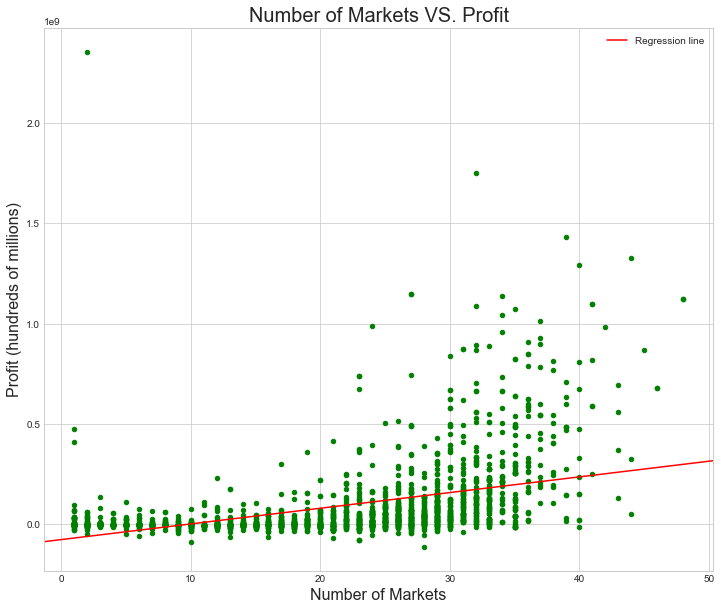

In [31]:
fig, ax3 = plt.subplots(figsize=(12,10))
fulldf.plot.scatter(x='num_markets', y='profit', ax=ax3, color='green')
ax3.set_title('Number of Markets VS. Profit', fontsize=20)
ax3.set_xlabel('Number of Markets', fontsize=16)
ax3.set_ylabel('Profit (hundreds of millions)', fontsize=16)
sm.graphics.abline_plot(model_results=NMPresults, label='Regression line', ax=ax3, color='red')
ax3.legend();

This is another case where it looks like the data could be better fit by an exponential graph, but in this analysis I will not analyze the residuals and apply the transformation to create the improved model.

I also want to determine whether the original language a movie is released in has a significant effect on the expected profit of the movie. To find the answer to this question, I just need to plot the graph of average profit by original language and visually inspect the result.

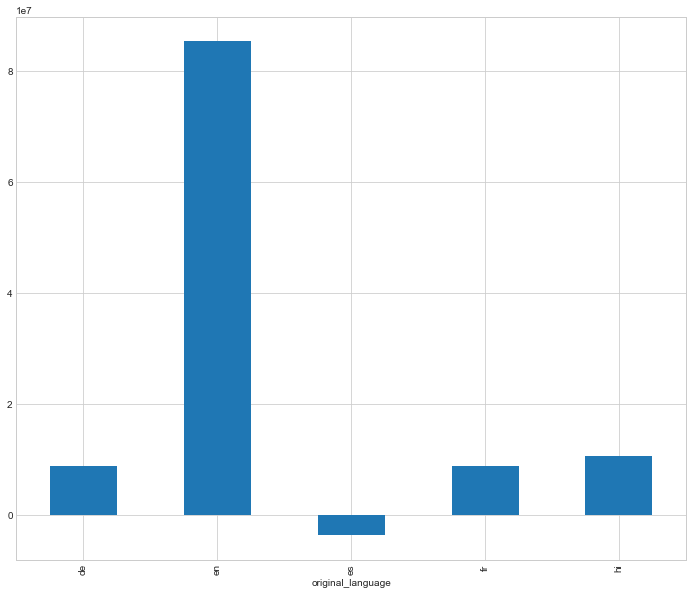

In [26]:
fig, ax4 = plt.subplots(figsize=(12,10))
langdf.groupby('original_language')['profit'].mean().plot.bar(ax=ax4);

This graph shows that there is an average baseline of roughly 1,000,000 profit which is expected for german, french, and hindi language movies. We also see that spanish language movies have an average loss of around 500,000 dollars. English language movies on the other hand are by far the most profitable according to this dataset - they are over 8 times as profitable as german, french, and hindi language movies. 

That English is the best original language to create a movie in is probably an assumption that most investors already have. However, this result reveals some interesting flaws in the data: it does not contain Japanese language or Chinese language movies, which also tend to be extremely popular in many markets - especially in recent years.

### Average Profit by Genre

The final question I think will be useful to my shareholders is what genre of movie to produce. I created a dictionary of average profit by genre earlier in the notebook, so all that is left for me to do here is to make a bargraph and visually inspect the results to see which genres are the best.

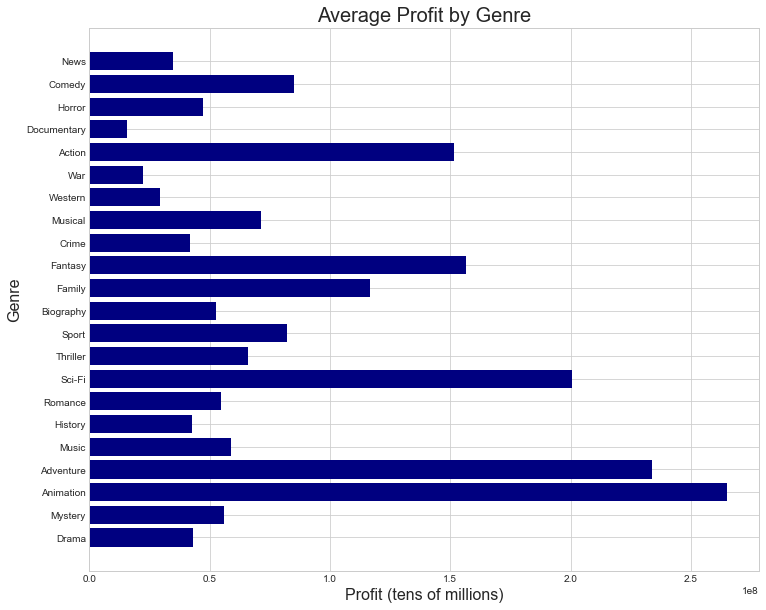

In [32]:
fig, ax5 = plt.subplots(figsize=(12,10))
plt.barh(range(len(genreprofitdict)), list(genreprofitdict.values()), align='center', color='navy')
plt.yticks(range(len(genreprofitdict)), list(genreprofitdict.keys()))
ax5.set_title('Average Profit by Genre', fontsize=20)
ax5.set_ylabel('Genre', fontsize=16)
ax5.set_xlabel('Profit (tens of millions)', fontsize=16);

By far, the most profitable genres are Animation, Adventure, and Sci-Fi, in that order. More research would be required to determine why this is the case, but it makes sense that Animation is the most profitable, because it is typically also the cheapest to produce. This is because it requires paying fewer actors for less time, and it does not require studios to spend large amounts of money on creating realistic special effects. Animated movies also have a very broad appeal as they are typically family friendly

## Conclusions

My analysis has created three conclusions about how investors should invest in new movies:
- **Maximize film production budget.** Film production budget is correlated with an increase in aggregate user ratins, which in turn are highly correlated with a large increase in profit per point of rating. There is effectively an exponential relationship between production budget and profit, so it is very important to invest as much as possible in the production of each individual movie, instead of churning out many low-budget movies. 
- **Maximize the number of markets that each film is released in.** This increases the size of the audience that the movies can be marketed to. My study also found that movies produced in English as the first language tended to perform much better than movies produced in other languages primarily. 
- **Produce movies in the Animation, Adventure, and Sci-Fi genres**. My analysis shows that these genres are significantly more profitable on average than other genres of movie.

## Next steps

There are more analyses that could potentially help investors narrow in on the best practices for consistently creating successful movies:
- **Create a multiple linear regression model of all the different factors that may contribute to aggregate movie scores.** It is very likely that my simple linear regression model's prediction of the relationship between initial investment and user ratings is missing out on several other factors that contribute to better scores. Investors could further increase their profits by finding and maximizing these other factors.
- **Determine which markets contribute the most to the profit of a movie and spend more money on advertising to those markets.** My analysis predicts a linear increase for each additional market that a movie is released in, but not all markets are created equal. Investors could further increase their profit by determining which markets contribute the most to sales and focusing advertising efforts on those markets.